In [1]:
import numpy as np 
import keras 
import tensorflow as tf 
from keras import layers,Model,Sequential,activations
from keras.callbacks import ModelCheckpoint, LearningRateScheduler 
from keras.callbacks import ReduceLROnPlateau 
from keras.regularizers import l2 
from keras.optimizers import Adam 
import matplotlib.pyplot as plt 
import keras.backend.tensorflow_backend as KTF 
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2" 
os.environ["HDF5_USE_FILE_LOCKING"] = 'FALSE' 
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
# config.gpu_options.allow_growth=True #不全部占满显存, 按需分配
sess = tf.Session(config=config)

Using TensorFlow backend.
/home/liyanni/anaconda3/envs/adv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/liyanni/anaconda3/envs/adv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/liyanni/anaconda3/envs/adv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/liyanni/anaconda3/en

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train_mean = np.mean(x_train, axis=0)
x_test -= x_train_mean
x_train -= x_train_mean
model = keras.models.load_model("/home/liyanni/1307/zwh/defense/models/cifar10/cifar10_ResNet56v2.h5")
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

In [3]:
model.evaluate(x_test,y_test)

10000/10000 [==============================] - 9s 941us/step


[0.4058270648002624, 0.9268]

In [6]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [4]:
logits = Model(inputs = model.input,
               outputs = model.get_layer('flatten_1').output)

In [5]:
logits.trainable = False
logits.name = 'cnn_logits'
fx_train = logits.predict(x_train)
fx_test = logits.predict(x_test)

In [7]:
# classifier
# 拿到model的最后一层
classifier = Sequential()
classifier.add(model.layers[-1])
classifier.build((None,256))
classifier.compile(loss='mean_absolute_error',
                   optimizer=Adam(),
                   metrics=['accuracy']
                )
classifier.trainable=False

In [8]:
#  cifar10 数据集 ID模型实现
def ID():
    x = layers.Input(shape=(32, 32, 3))
    # forword
    x1 = C2(x,64) # (32,32,64)
    x2 = forword_C3(x1,128) # (16,16,128)
    x3 = forword_C3(x2,256) # (8,8,256)
    x4 = forword_C3(x3,256) # (4,4,256)
    
    # backword    
    x3 = F(x3,x4) # (8,8,512)
    x3 = backword_C3(x3,256) #(8,8,256)
    x2 = F(x2,x3) #(16,16,384)
    x2 = backword_C3(x2,128) #(16,16,128)
    x1 = F(x1,x2) #(32,32,192)
    x1 = C2(x1,64) #(32,32,64)
    
    # x + noise    
    noise = layers.Conv2D(filters=3,kernel_size=(1,1))(x1) #(32,32,3)
    y = layers.Add()([x,noise])
    
    # get logits
    y = logits(y)
    return Model(inputs = x,outputs = y)
    
def C2(x,out_channels):
    x = layers.Conv2D(filters=out_channels,kernel_size=(3,3),padding='same',kernel_initializer='he_normal',kernel_regularizer=l2(1e-3))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters=out_channels,kernel_size=(3,3),padding='same',kernel_initializer='he_normal',kernel_regularizer=l2(1e-3))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x
    
def forword_C3(x,out_channels):
    x = layers.Conv2D(filters=out_channels,kernel_size=(3,3),strides=(2,2),padding='same',kernel_initializer='he_normal',kernel_regularizer=l2(1e-3))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters=out_channels,kernel_size=(3,3),padding='same',kernel_initializer='he_normal',kernel_regularizer=l2(1e-3))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters=out_channels,kernel_size=(3,3),padding='same',kernel_initializer='he_normal',kernel_regularizer=l2(1e-3))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

def backword_C3(x,out_channels):
    x = layers.Conv2D(filters=out_channels,kernel_size=(3,3),padding='same',kernel_initializer='he_normal',kernel_regularizer=l2(1e-3))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters=out_channels,kernel_size=(3,3),padding='same',kernel_initializer='he_normal',kernel_regularizer=l2(1e-3))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters=out_channels,kernel_size=(3,3),padding='same',kernel_initializer='he_normal',kernel_regularizer=l2(1e-3))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

def F(input1,input2):
    input2 = layers.UpSampling2D(interpolation='bilinear')(input2)
    output = layers.concatenate([input1,input2],axis=-1)
    return output


In [9]:
# 定义回调函数
def lr_schedule(epoch):
    """Learning Rate Schedule
    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.
    # Arguments
        epoch (int): The number of epochs
    # Returns
        lr (float32): learning rate
    """
    lr = 0.001
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('lr:',lr)
    return lr
lr_scheduler = LearningRateScheduler(lr_schedule)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)
callbacks = [lr_reducer, lr_scheduler]

In [10]:
x_adv = np.load("../defense/adv_data/cifar10/fgsm/0.06x_adv.npy")
# label = np.append(y_train,y_test,axis=0)

In [11]:
x_train_adv = x_adv[:50000]
x_test_adv = x_adv[50000:]

In [33]:
model.evaluate(x_test_adv,y_test)

10000/10000 [==============================] - 6s 560us/step


[0.4058270648002624, 0.9268]

In [ ]:
denoiser = ID()
denoiser.compile(loss='mean_absolute_error',
              optimizer=Adam(lr = lr_schedule(0))
                )
              
batch_size = 128
epochs = 100

In [27]:
denoiser.fit(x_train_adv,fx_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test_adv,fx_test),
              shuffle=True,
              callbacks=callbacks
            )

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
lr: 0.001
50000/50000 [==============================] - 93s 2ms/step - loss: 0.2006 - val_loss: 0.2976
Epoch 2/20
lr: 0.001
50000/50000 [==============================] - 93s 2ms/step - loss: 0.2007 - val_loss: 0.2946
Epoch 3/20
lr: 0.001
50000/50000 [==============================] - 93s 2ms/step - loss: 0.2005 - val_loss: 0.2714
Epoch 4/20
lr: 0.001
50000/50000 [==============================] - 92s 2ms/step - loss: 0.2001 - val_loss: 0.2702
Epoch 5/20
lr: 0.001
32384/50000 [==================>...........] - ETA: 30s - loss: 0.2004

KeyboardInterrupt: 

In [29]:
hidden = denoiser.predict(x_test)
classifier.evaluate(hidden,y_test)

10000/10000 [==============================] - 1s 71us/step


[0.05922351468801498, 0.7185]

In [30]:
denoiser.save("denoiser.h5")

In [31]:
fx_train_adv = denoiser.predict(x_train_adv)
fx_test_adv = denoiser.predict(x_test_adv)
fx_train = denoiser.predict(x_train)
fx_test = denoiser.predict(x_test)

In [37]:
train_group = []
(_, train_label), (_,test_label) = keras.datasets.cifar10.load_data()
train_label = train_label.reshape(-1)
for i in range(10):
    train_index = np.argwhere(train_label == i).reshape(-1)
    tmp = np.append(fx_train[train_index],fx_train_adv[train_index],axis=0)
    train_group.append(tmp)
# shuffle
for i in range(10):
    permutation = np.random.permutation(train_group[i].shape[0])
    train_group[i] = train_group[i][permutation]

In [35]:
def HR():
    x = layers.Input(shape=(256,))
    x1 = layers.Dense(256)(x)
    layers.Dropout(0.2)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.ReLU()(x1)
    x2 = layers.Dense(128)(x1)
    layers.Dropout(0.2)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.ReLU()(x2)
    x3 = layers.Dense(64)(x2)
    layers.Dropout(0.2)
    x3 = layers.BatchNormalization()(x3)
    x3 = layers.ReLU()(x3)
    x4 = layers.Dense(32)(x3)
    layers.Dropout(0.2)
    x4 = layers.BatchNormalization()(x4)
    x4 = layers.ReLU()(x4)
    x4 = layers.Dense(64)(x4)
    layers.Dropout(0.2)
    x4 = layers.BatchNormalization()(x4)
    x4 = layers.ReLU()(x4)
    x4 = layers.add([x3,x4])
    x4 = layers.Dense(128)(x4)
    layers.Dropout(0.2)
    x4 = layers.BatchNormalization()(x4)
    x4 = layers.ReLU()(x4)
    x4 = layers.add([x2,x4])
    x4 = layers.Dense(256)(x4)
    layers.Dropout(0.2)
    x4 = layers.BatchNormalization()(x4)
    x4 = layers.ReLU()(x4)
    x4 = layers.add([x1,x4])
    x4 = classifier(x4)
    return Model(inputs = x,outputs = x4)

In [38]:
def generator():
    while True:
        x,y=[],[]
        for _ in range(96):
            label = np.random.randint(10)
            length = len(train_group[label])
            v1=np.random.randint(length)
            v2=np.random.randint(length)
            rate1 = np.random.randint(1,11)/10
            rate2 = 1-rate1
            x.append(rate1*train_group[label][v1]+rate2*train_group[label][v2])
            lb = np.zeros(10)
            lb[label]=1
            y.append(lb)
        x = np.array(x)
        y = np.array(y)
        yield x,y
dataGen = generator()

In [39]:
hr = HR()
hr.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr = lr_schedule(0)),
                  metrics=['accuracy']
                )
hr.fit_generator(dataGen,
              steps_per_epoch=500,
              epochs=80, 
              verbose=1, 
              validation_data=(fx_test,y_test),
              callbacks=callbacks)

lr: 0.001
Epoch 1/80
lr: 0.001
500/500 [==============================] - 18s 35ms/step - loss: 0.7813 - acc: 0.8444 - val_loss: 1.3266 - val_acc: 0.7418
Epoch 2/80
lr: 0.001
500/500 [==============================] - 10s 20ms/step - loss: 0.3793 - acc: 0.8855 - val_loss: 0.9836 - val_acc: 0.7574
Epoch 3/80
lr: 0.001
500/500 [==============================] - 10s 20ms/step - loss: 0.3177 - acc: 0.8983 - val_loss: 1.0302 - val_acc: 0.7538
Epoch 4/80
lr: 0.001
500/500 [==============================] - 10s 20ms/step - loss: 0.2950 - acc: 0.9045 - val_loss: 0.9647 - val_acc: 0.7563
Epoch 5/80
lr: 0.001
500/500 [==============================] - 10s 21ms/step - loss: 0.2784 - acc: 0.9062 - val_loss: 0.9465 - val_acc: 0.7541
Epoch 6/80
lr: 0.001
500/500 [==============================] - 10s 19ms/step - loss: 0.2669 - acc: 0.9088 - val_loss: 0.8964 - val_acc: 0.7626
Epoch 7/80
lr: 0.001
500/500 [==============================] - 10s 20ms/step - loss: 0.2608 - acc: 0.9109 - val_loss: 0.7781 

500/500 [==============================] - 10s 19ms/step - loss: 0.1486 - acc: 0.9465 - val_loss: 0.8441 - val_acc: 0.7845
Epoch 58/80
lr: 0.001
500/500 [==============================] - 10s 21ms/step - loss: 0.1546 - acc: 0.9436 - val_loss: 0.7561 - val_acc: 0.7988
Epoch 59/80
lr: 0.001
500/500 [==============================] - 11s 22ms/step - loss: 0.1492 - acc: 0.9464 - val_loss: 0.7864 - val_acc: 0.7958
Epoch 60/80
lr: 0.001
500/500 [==============================] - 10s 21ms/step - loss: 0.1471 - acc: 0.9463 - val_loss: 0.8155 - val_acc: 0.7934
Epoch 61/80
lr: 0.001
500/500 [==============================] - 11s 22ms/step - loss: 0.1490 - acc: 0.9466 - val_loss: 0.7941 - val_acc: 0.7946
Epoch 62/80
lr: 0.001
500/500 [==============================] - 11s 21ms/step - loss: 0.1448 - acc: 0.9481 - val_loss: 0.8086 - val_acc: 0.7881
Epoch 63/80
lr: 0.001
500/500 [==============================] - 11s 22ms/step - loss: 0.1457 - acc: 0.9470 - val_loss: 0.8315 - val_acc: 0.7939
Epoch 6

In [48]:
classifier.evaluate(fx_test,y_test)

10000/10000 [==============================] - 1s 65us/step


[0.0738240493953228, 0.6477]

In [47]:
hr.evaluate(fx_test,y_test)

10000/10000 [==============================] - 1s 134us/step


[0.8701623602598906, 0.7846]

In [90]:
from sklearn.preprocessing import MinMaxScaler
def mm(data):
    '''
    归一化处理
    :return:
    '''
    mm = MinMaxScaler(feature_range=(0,1))
    data = mm.fit_transform(data)
    return data

In [ ]:
["peru","dodgerblue","brown","darkslategray","springgreen","dimgray","fuchsia","orangered","gold","olive"]

In [69]:
from sklearn.decomposition import PCA

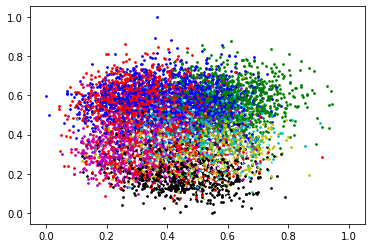

In [101]:
data = mm(fx_test)
pca = PCA(n_components=2)
newX = pca.fit_transform(data)
newX = mm(newX)
for i in range(len(newX)):
    plt.scatter(newX[i][0], newX[i][1], c = color[int(test_label[i])], s = 3)
plt.show()

In [62]:
restorer = Model(inputs = hr.input,
               outputs = hr.get_layer('add_4').output)

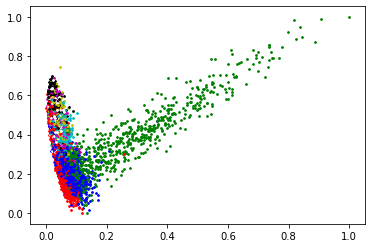

In [99]:
restored_fx_test = restorer.predict(fx_test)
data = mm(restored_fx_test)
pca = PCA(n_components=2)
newX1 = pca.fit_transform(data)
newX1 = mm(newX1)
for i in range(len(newX1)):
    plt.scatter(newX1[i][0], newX1[i][1], c = color[int(test_label[i])], s = 3)
plt.show()

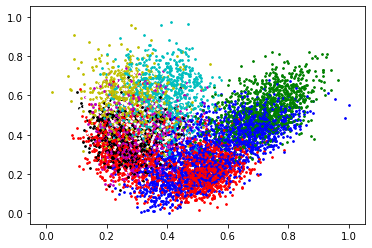

In [100]:
ori_fx_test = logits.predict(x_test)
data = mm(ori_fx_test)
pca = PCA(n_components=2)
newX2 = pca.fit_transform(data)
newX2 = mm(newX2)
for i in range(len(newX2)):
    plt.scatter(newX2[i][0], newX2[i][1], c = color[int(test_label[i])], s = 3)
plt.show()